In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# モジュールのインポート
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
import copy
import json

In [22]:
# 自作モジュール
sys.path.append("../src")
import dataloader
import module_extraction
from module_extraction import Filters, Modules
import anomaly_detection
from anomaly_detection import HotspotDetectors, AnomalyTypeClassifier
import utils

分析対象の指定

In [5]:
input_img_path = "../images/ortho/1466.tif"
#input_img_path = "../images/ortho/1391.tif"
input_dir_path = "../outputs/"+input_img_path.split("/")[-1][:-4]
print(input_dir_path)

../outputs/1466


画像データの取得

In [6]:
img_org = cv2.imread(input_img_path, 0)

In [7]:
thermal_img_files = dataloader.get_img_files(dir_path=input_dir_path+"/modules",gray=False)

モジュール情報の取得

In [8]:
import pickle
with open(input_dir_path+'/module_contours.pkl', 'rb') as pkl:
    module_contours = pickle.load(pkl)
with open(input_dir_path+'/module_labels_split.pkl', 'rb') as pkl:
    module_labels = pickle.load(pkl)

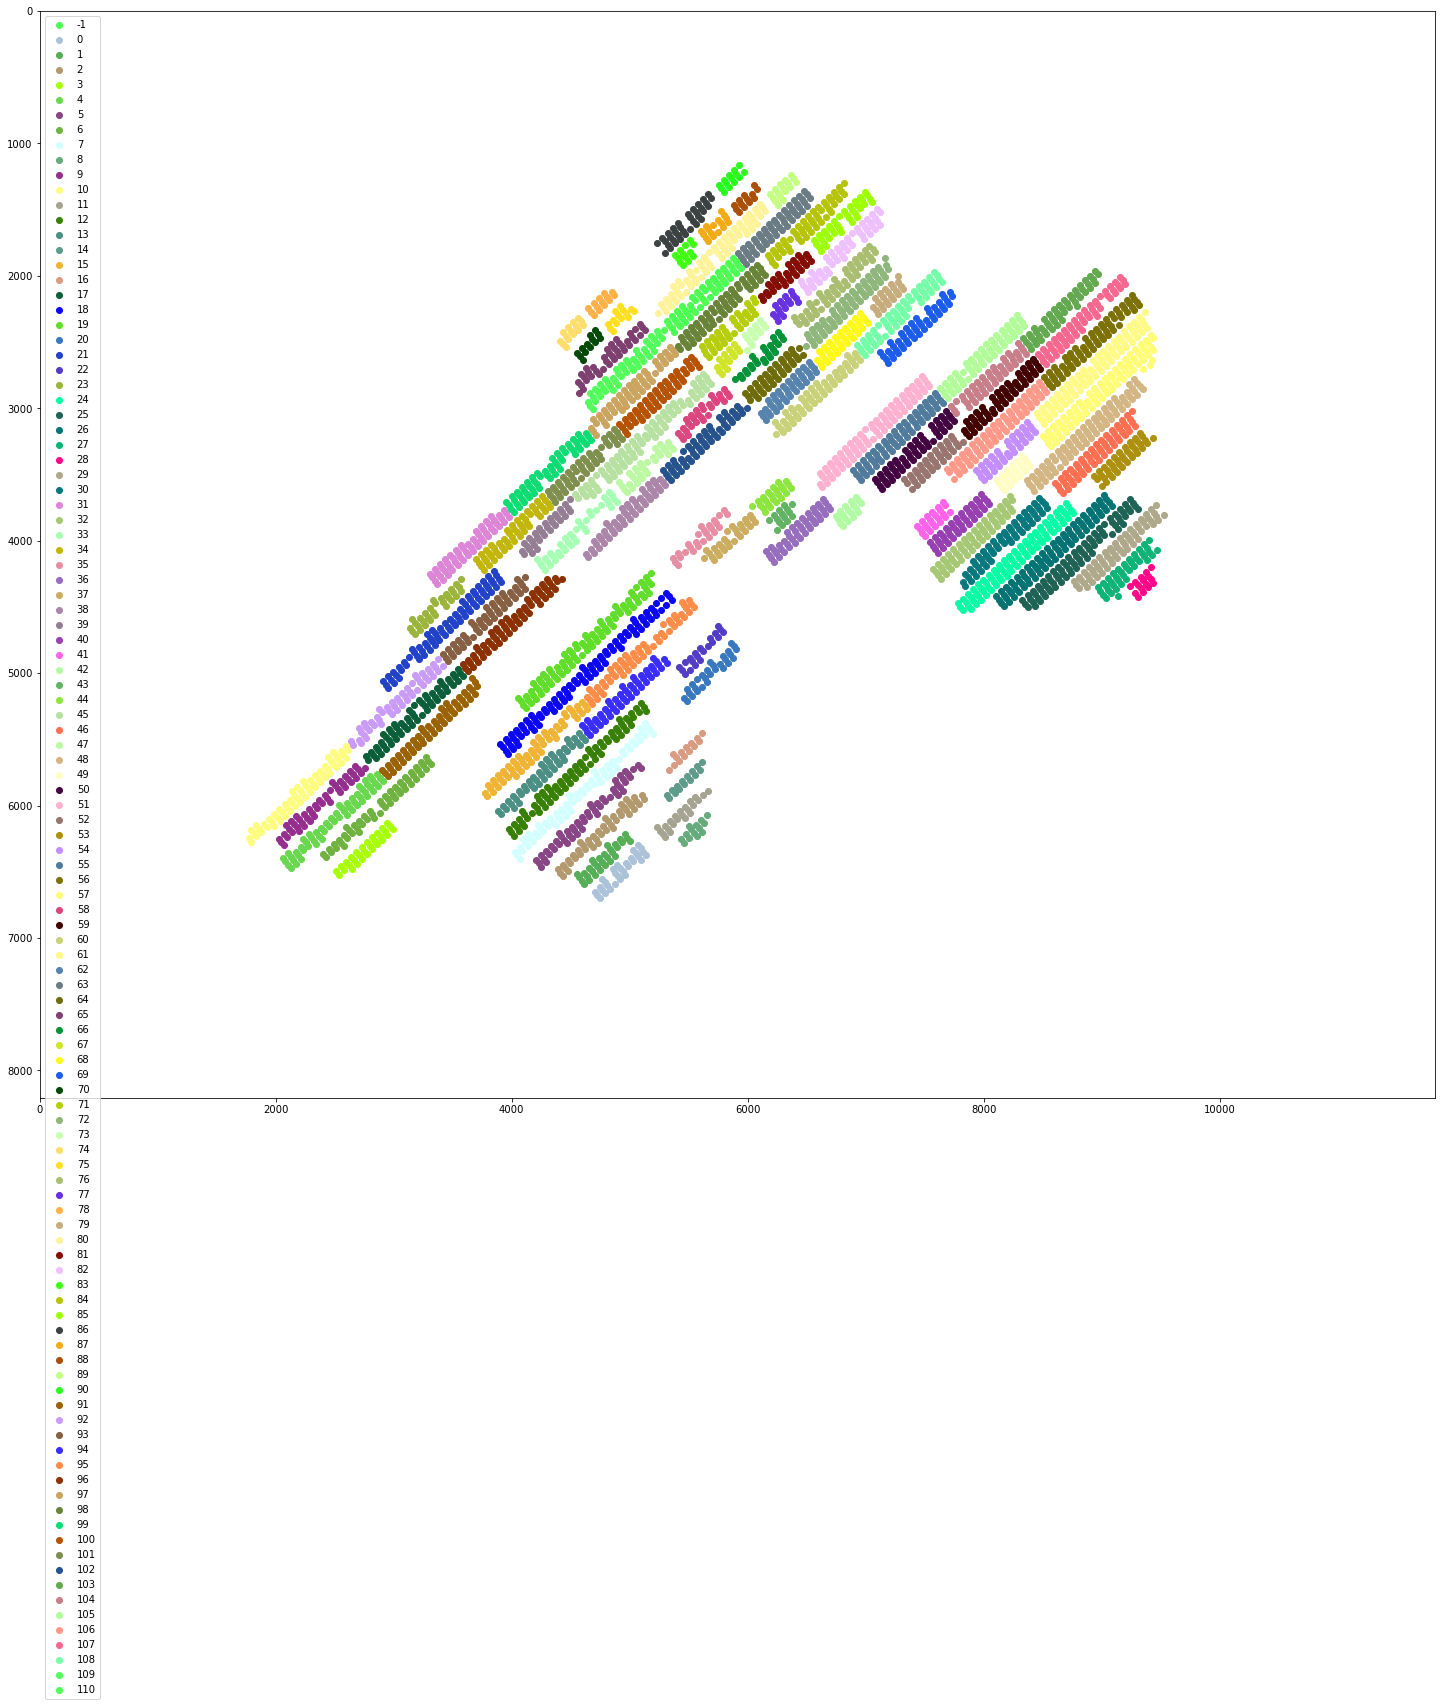

In [9]:
module_extraction.plot_module_map_with_labels(img_org, module_contours, module_labels)

温度データの取得

In [10]:
%%time
# This part requires expensive calculations
thermal_data = dataloader.get_thermal_data(thermal_img_files, module_labels) # group

100%|██████████| 111/111 [09:11<00:00,  4.97s/it]

CPU times: user 41min 23s, sys: 2min 34s, total: 43min 58s
Wall time: 9min 11s


ホットスポット検出モデルの学習

In [11]:
detectors = HotspotDetectors()

In [12]:
%%time
detectors.fit(thermal_data, module_labels)

100%|██████████| 111/111 [00:13<00:00,  8.36it/s]

CPU times: user 13.4 s, sys: 359 ms, total: 13.8 s
Wall time: 13.5 s


In [13]:
# -- check outliers (blue plots) --
#detectors.check_pred_labels(thermal_data, module_labels, anomodels.lof, anomodels.isof)

異常検知の実行

In [14]:
classifier = AnomalyTypeClassifier(detectors)

In [15]:
list_anomaly_modules = [
    "172.jpg", 
    "300.jpg",                 
    "717.jpg",         
    "877.jpg",     
    "900.jpg",         
    "1248.jpg",             
    "1397.jpg",                 
    "1531.jpg",         
    "1638.jpg",     
    "1705.jpg",         
    "1955.jpg",     
    "3237.jpg",             
    "4036.jpg",         
    "4517.jpg",             
    "4908.jpg",             
]

3237.jpg Cluster-Anomaly


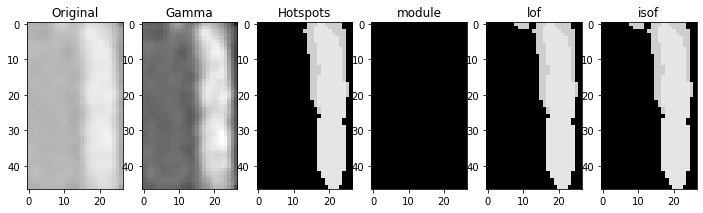

1397.jpg Single-Hotspot


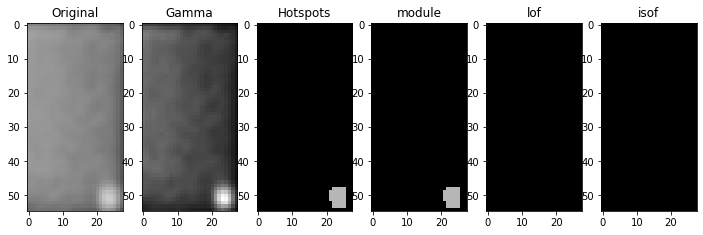

172.jpg Single-Hotspot


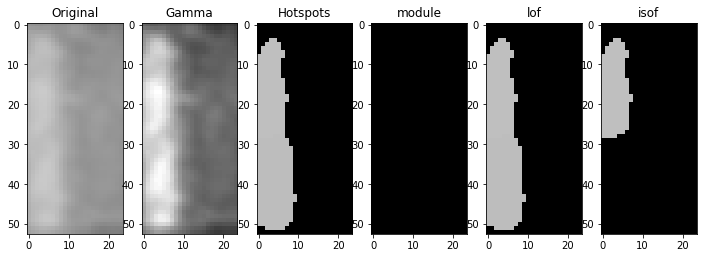

4908.jpg Normal
300.jpg Single-Hotspot


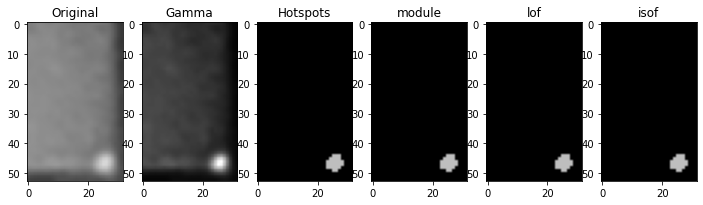

1531.jpg Single-Hotspot


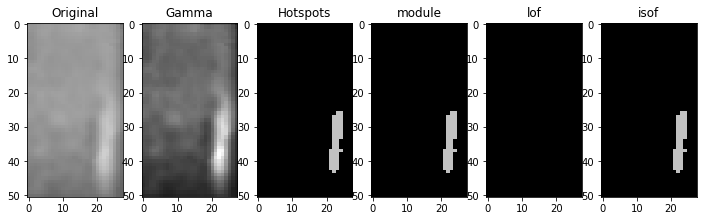

4517.jpg Single-Hotspot


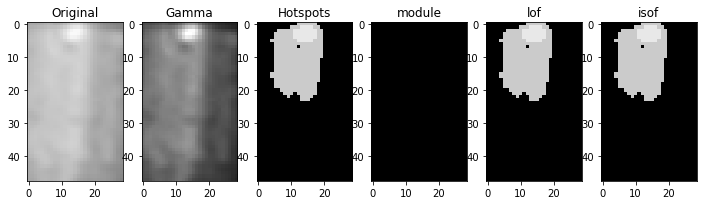

717.jpg Single-Hotspot


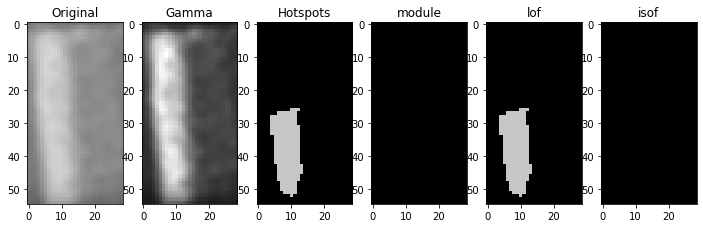

900.jpg Single-Hotspot


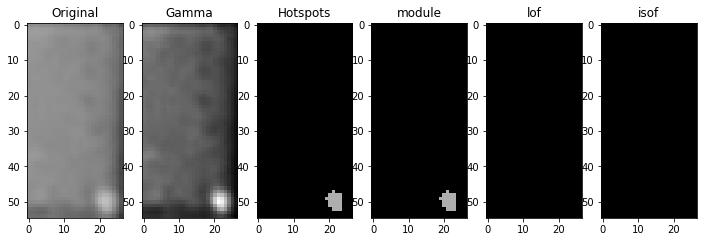

877.jpg Single-Hotspot


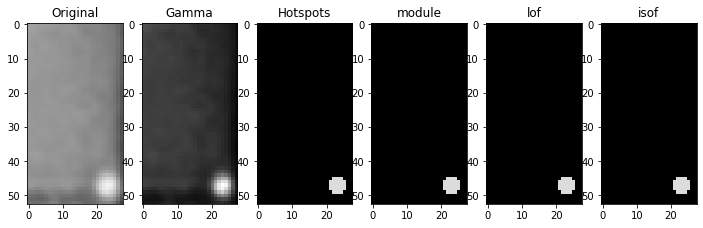

1248.jpg Single-Hotspot


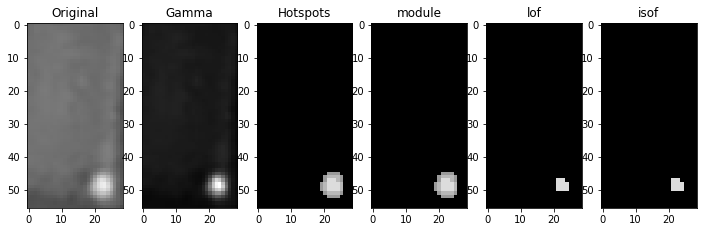

1705.jpg Single-Hotspot


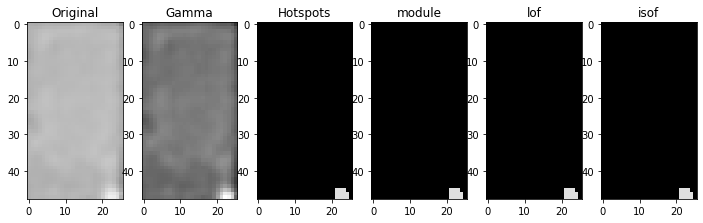

4036.jpg Module-Anomaly


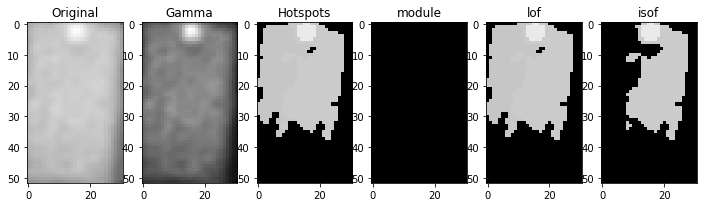

1638.jpg Multi-Hotspots


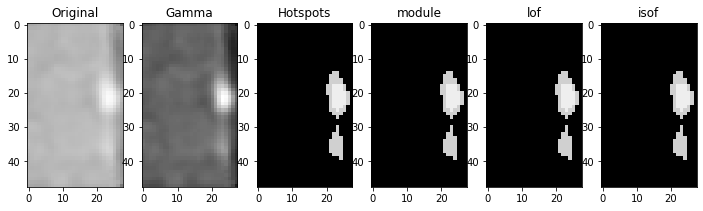

1955.jpg Single-Hotspot


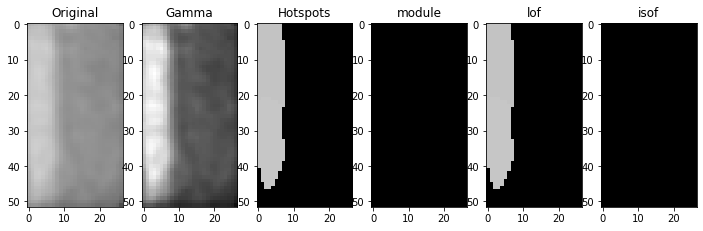

CPU times: user 6.41 s, sys: 241 ms, total: 6.65 s
Wall time: 6.65 s


In [16]:
%%time
anomaly_modules = classifier.run(
    thermal_img_files, thermal_data, module_labels, input_dir_path, list_anomaly_modules)

異常モジュール可視化

In [17]:
modules = Modules(module_contours)
anomaly_contours = modules.get_anomaly_contours(anomaly_modules)

In [18]:
# ストリング異常の付与
if "Module-Anomaly" in anomaly_modules:
    string_anomaly_labels = modules.get_dbscan_labels(anomaly_contours["Module-Anomaly"])
    string_anomaly_modules = np.array(anomaly_modules["Module-Anomaly"])[string_anomaly_labels > 0]
    anomaly_modules["String-Anomaly"] = list(string_anomaly_modules )
    anomaly_contours = modules.get_anomaly_contours(anomaly_modules)

In [19]:
img_con = cv2.drawContours(np.zeros_like(img_org), module_contours, -1, 255, -1)
img_mask = cv2.bitwise_and(img_org, img_con)
img_mask_index = modules.add_index(img_mask)

In [20]:
#plt.imshow(img_mask_index)

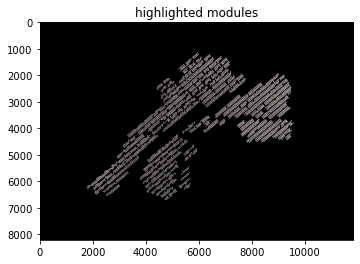

In [23]:
color_list = {
    "Single-Hotspot": (0,255,255), # aqua
    "Multi-Hotspots": (0,255,0), # green
    "Cluster-Anomaly": (255,255,0), # yellow
    "Module-Anomaly": (255,165,0), # orange
    "String-Anomaly": (238,130,238) # violet
}
img_target_index = copy.deepcopy(img_mask_index)
for k, v in anomaly_contours.items():
    if k in  ["Normal", "Junction-Box-Error"]:
        continue
    else:
        img_target_index = modules.get_img_target_contours(
            img_target_index, v, index=True, color=color_list[k])
utils.show_img(
    {"highlighted modules":img_target_index}, cmap="gray", figsize=(30,30)
)

In [24]:
img_write = cv2.cvtColor(img_target_index, cv2.COLOR_BGR2RGB)
cv2.imwrite(input_dir_path+'/img_target_index.png',img_write)

True

異常モジュールデータの保存

In [25]:
with open(input_dir_path+"/anomaly_modules.json", "w") as f:
    json.dump(anomaly_modules, f, indent=4, sort_keys=True, separators=(',', ': '))